In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.family': 'sans serif'})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.fontset':'stixsans'})
plt.rcParams.update({'axes.linewidth': 1.5})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'xtick.major.size': 5})
plt.rcParams.update({'xtick.major.width': 1.25 })
plt.rcParams.update({'xtick.minor.size': 2.5})
plt.rcParams.update({'xtick.minor.width': 1.25 })
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'ytick.major.size': 5})
plt.rcParams.update({'ytick.major.width': 1.25 })
plt.rcParams.update({'ytick.minor.size': 2.5})
plt.rcParams.update({'ytick.minor.width': 1.25 })

import warnings
warnings.filterwarnings("ignore")

from IPython import display

T_colors = ["lightskyblue", "violet", "forestgreen", "darkviolet", "thistle", "cadetblue", 
            "palegoldenrod", "darksalmon", "indigo"]

import h5py

import glob
import os
os.chdir("/Users/helenarichie/GitHub/analysis_scripts/")
from cholla_py_utils import ChollaPyUtils
os.chdir("/Users/helenarichie/GitHub/research/cholla/dust_model/cloud-wind/")
cholla_helper = ChollaPyUtils()

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [24]:
def load_data(test):
    files = sorted(glob.glob(os.path.join("cholla_out/", test, "*.h5.0")))
    n_out = len(files)
    test = "bkgd_v"

    nx, ny, nz = None, None, None
    dx, dy, dz = None, None, None

    t_arr = []

    d_gas, d_dust = [], []

    vx = []
    T, P = [], []

    n = []
    n_dust = []
    i_out = np.arange(0, n_out)
    dname = f"./cholla_out/{test}/"
    
    for i in i_out:
        f = h5py.File(dname + str(i) + ".h5.0", "r")
        head = f.attrs # Allows dictionary-style access to an HDF5 object's attributes.
        a_group_key = list(f.keys())

        nx = head['dims'][0]
        ny = head['dims'][1]
        nz = head['dims'][2]

        dx = cholla_helper.l_cgs(head['dx'][0]) # dimensions of a cell, x direction, in code units
        dy = cholla_helper.l_cgs(head['dx'][0])
        dz = cholla_helper.l_cgs(head['dx'][0])

        t_arr.append(np.array(cholla_helper.t_cgs(head["t"])/cholla_helper._YR_IN_S)) # time in cgs units

        d_gas.append(np.array(cholla_helper.d_cgs(np.array(f["density"])))) # mass density in cgs units
        d_dust.append(np.array(cholla_helper.d_cgs(np.array(f["scalar0"]))))

        d_gas_ch = np.array(f["density"]) # mass density in code units

        mx = np.array(f["momentum_x"])
        my = np.array(f["momentum_y"])
        mz = np.array(f["momentum_z"])
        E_ch = np.array(f["Energy"]) # total energy density in code units
        vx_ch = mx / d_gas_ch
        vy_ch = my / d_gas_ch
        vz_ch = mz / d_gas_ch
        
        vx.append(vx_ch/cholla_helper._VELOCITY_UNIT)
        T.append(np.array(cholla_helper.calc_T(E_ch, vx_ch, vy_ch, vz_ch, d_gas_ch)))
        P.append(np.array(cholla_helper.calc_P_cgs(T[i], cholla_helper.calc_n_cgs(d_gas[i]))))

        n.append(d_gas[i]/(cholla_helper._mu*cholla_helper._MP)) # number density, particles per cm^3
        n_dust.append(d_dust[i]/(cholla_helper._mu*cholla_helper._MP)) # number density, particles per cm^3

    return [t_arr, d_gas, d_dust, T, P, n, [nx, ny, nz], [dx, dy, dz], n_dust, vx]

In [25]:
datav10 = load_data("v10")

In [26]:
def plotter(data, quantity):
    t_arr = data[0]
    d_gas = data[1]
    d_dust = data[2]
    n = data[5]
    n_dust = data[8]
    nx, ny, nz = data[6][0], data[6][1], data[6][2] 
    dx, dy, dz = data[7][0], data[7][1], data[7][2]
    vx = data[9]
    
    fig, axs = plt.subplots(5, 2, figsize=(10,20), gridspec_kw={'width_ratios': [1, 2]})    
    
    
    if quantity == "gas":
        n_sub = n[::2]
        n_sub = n_sub[:-1]
    if quantity == "dust":
        n_sub = n_dust[::2]
        n_sub = n_sub[:-1]
    if quantity == "velocity":
        n_sub = vx[::2]
        n_sub = n_sub[:-1]

    t_sub = t_arr[::2]
    t_sub = t_sub[:-1]

    for i, n_i in enumerate(n_sub):
        # plot the surface density, x-axis projection
        pn_x = np.sum(n_i, axis=0)*dx
        pn_y = np.sum(n_i, axis=1)*dx
        log_pn_x = np.log10(pn_x)
        log_pn_y = np.log10(pn_y)
        axs[i][0].set_xticks(ny*np.arange(0.25, 1, 0.25))
        axs[i][0].set_yticks(nz*np.arange(0.25, 1, 0.25))
        axs[i][0].tick_params(axis='both', which='both', direction='in', color='white', top=1, right=1)
        image = axs[i][0].imshow(log_pn_x.T, origin='lower', cmap='viridis')
        axs[i][0].text(10, 15, '$Time={:.1e}~yr$'.format(t_sub[i][0]), bbox={'facecolor': 'white', 'pad': 8}, fontsize=10)

        axs[i][0].set_xlabel(r"$y$")
        axs[i][0].set_ylabel(r"$z$")

        pn_x = np.sum(n_i, axis=0)*dx
        pn_y = np.sum(n_i, axis=1)*dx
        log_pn_x = np.log10(pn_x)
        log_pn_y = np.log10(pn_y)
        image = axs[i][1].imshow(log_pn_y.T, origin='lower', cmap='viridis')
        axs[i][1].text(10, 15, '$Time={:.1e}~yr$'.format(t_sub[i][0]), bbox={'facecolor': 'white', 'pad': 8}, fontsize=10)
        # add a scale bar
        axs[i][1].set_xticks(nx*np.arange(0.25, 1, 0.25))
        axs[i][1].set_yticks(nz*np.arange(0.25, 1, 0.25))
        axs[i][1].tick_params(axis='both', which='both', direction='in', color='white', top=1, right=1)
        axs[i][1].set_xlabel(r"$x$")
        axs[i][1].set_ylabel(r"$z$")
        plt.xlim(0, nx) # maybe you only want to show part of the plot
        # add the simulation time (this label assumes you ran with code units of kyr)
    divider = make_axes_locatable(axs[0][1])
    cbax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(image, cax = cbax)
    cbax.tick_params(axis='y', direction='in')
    cb.solids.set_edgecolor('face')
    cbax.set_ylabel(r'$\mathrm{log}_{10}(N_{H})$ [$\mathrm{cm}^{-2}$]')
    divider = make_axes_locatable(axs[1][1])
    cbax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(image, cax = cbax)
    cbax.tick_params(axis='y', direction='in')
    cb.solids.set_edgecolor('face')
    cbax.set_ylabel(r'$\mathrm{log}_{10}(N_{H})$ [$\mathrm{cm}^{-2}$]')
    divider = make_axes_locatable(axs[2][1])
    cbax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(image, cax = cbax)
    cbax.tick_params(axis='y', direction='in')
    cb.solids.set_edgecolor('face')
    cbax.set_ylabel(r'$\mathrm{log}_{10}(N_{H})$ [$\mathrm{cm}^{-2}$]')
    divider = make_axes_locatable(axs[3][1])
    cbax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(image, cax = cbax)
    cbax.tick_params(axis='y', direction='in')
    cb.solids.set_edgecolor('face')
    cbax.set_ylabel(r'$\mathrm{log}_{10}(N_{H})$ [$\mathrm{cm}^{-2}$]')
    divider = make_axes_locatable(axs[4][1])
    cbax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(image, cax = cbax)
    cbax.tick_params(axis='y', direction='in')
    cb.solids.set_edgecolor('face')
    cbax.set_ylabel(r'$\mathrm{log}_{10}(N_{H})$ [$\mathrm{cm}^{-2}$]')

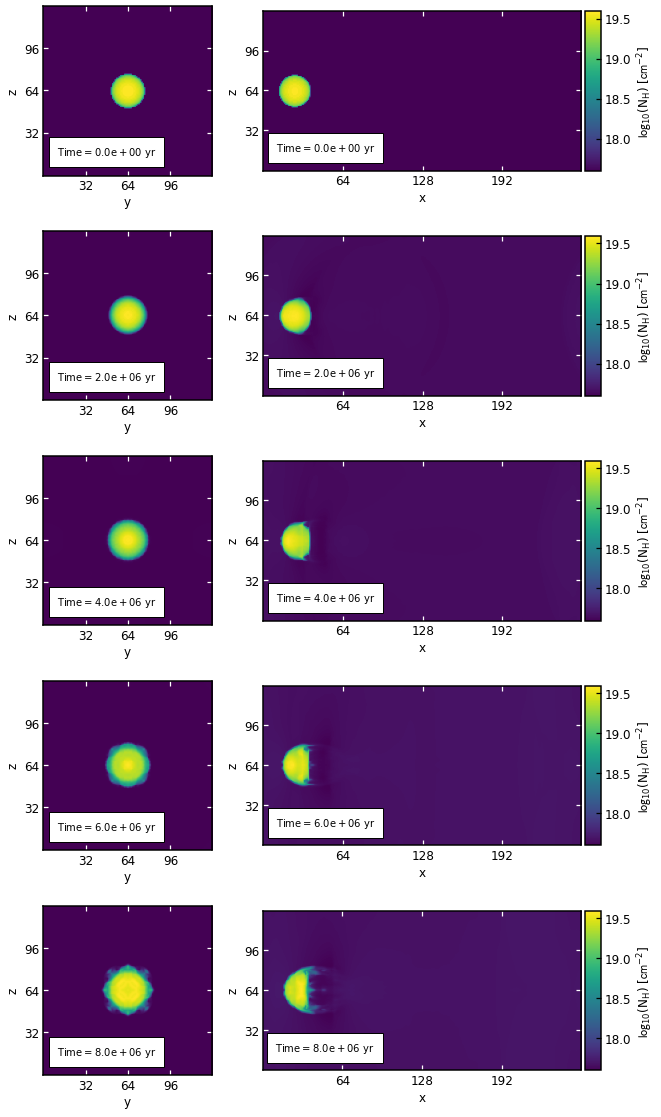

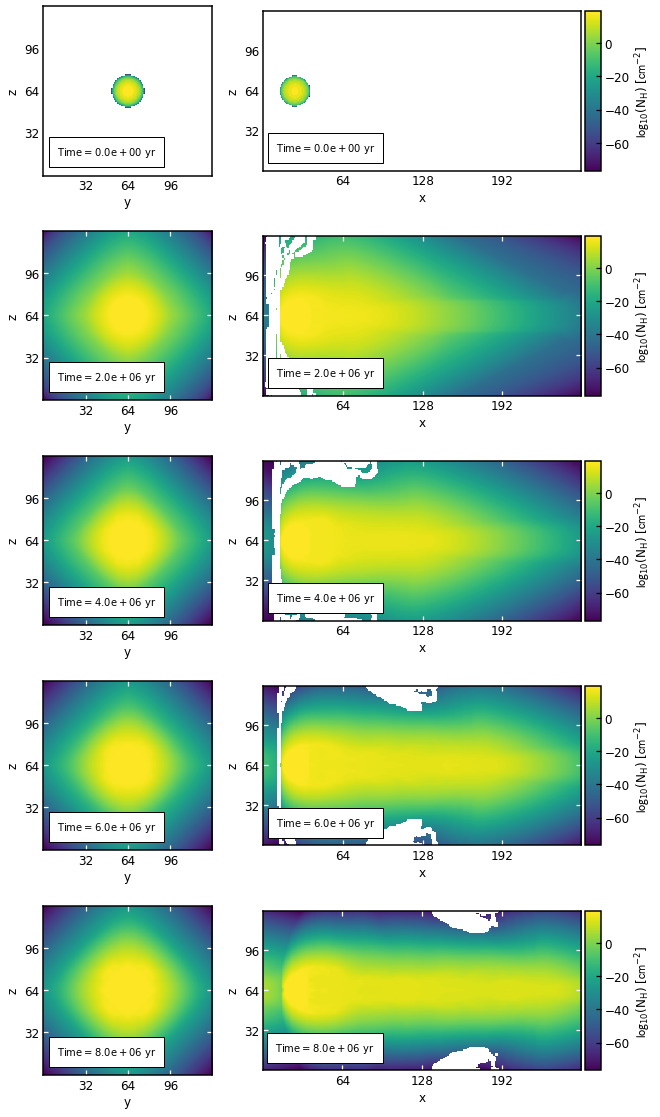

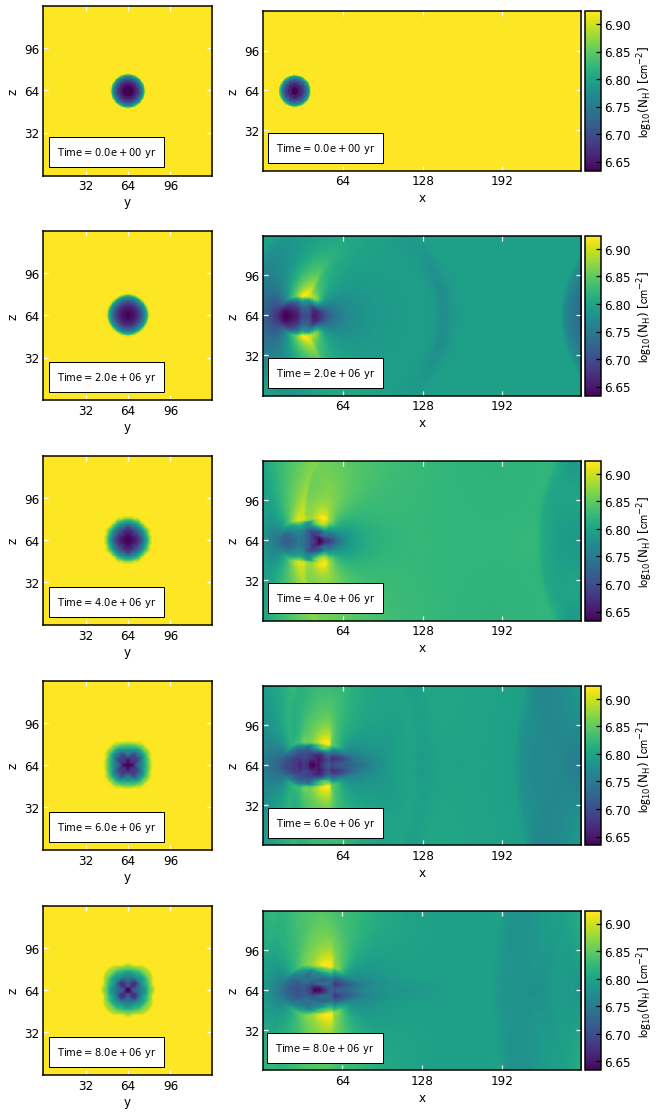

In [27]:
plotter(datav10, "gas")
plotter(datav10, "dust")
plotter(datav10, "velocity")

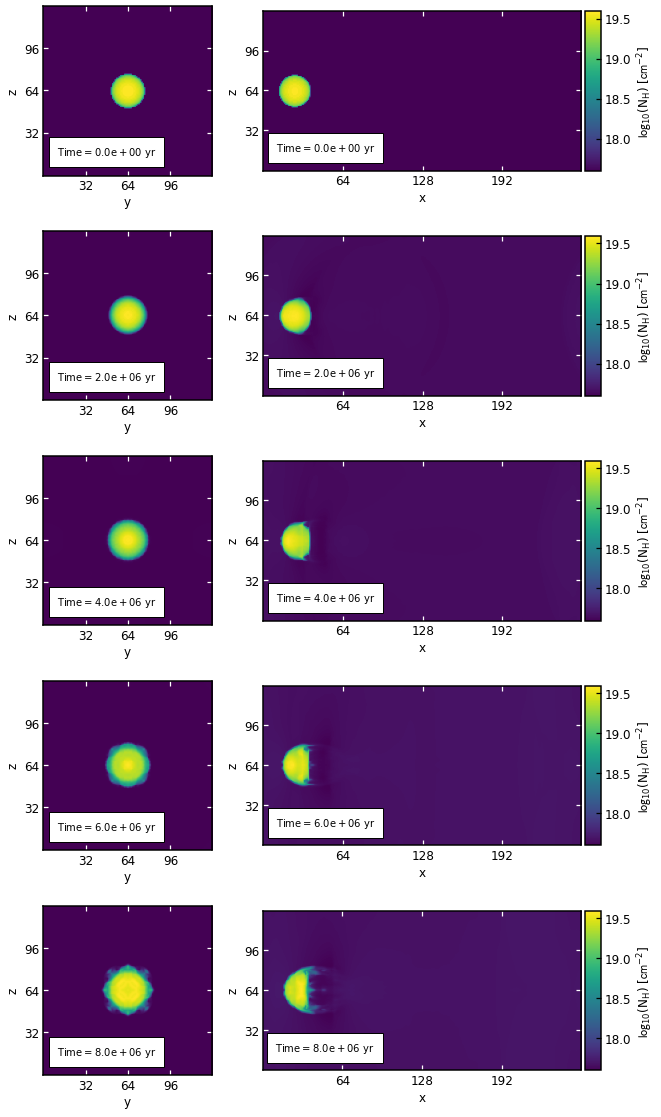

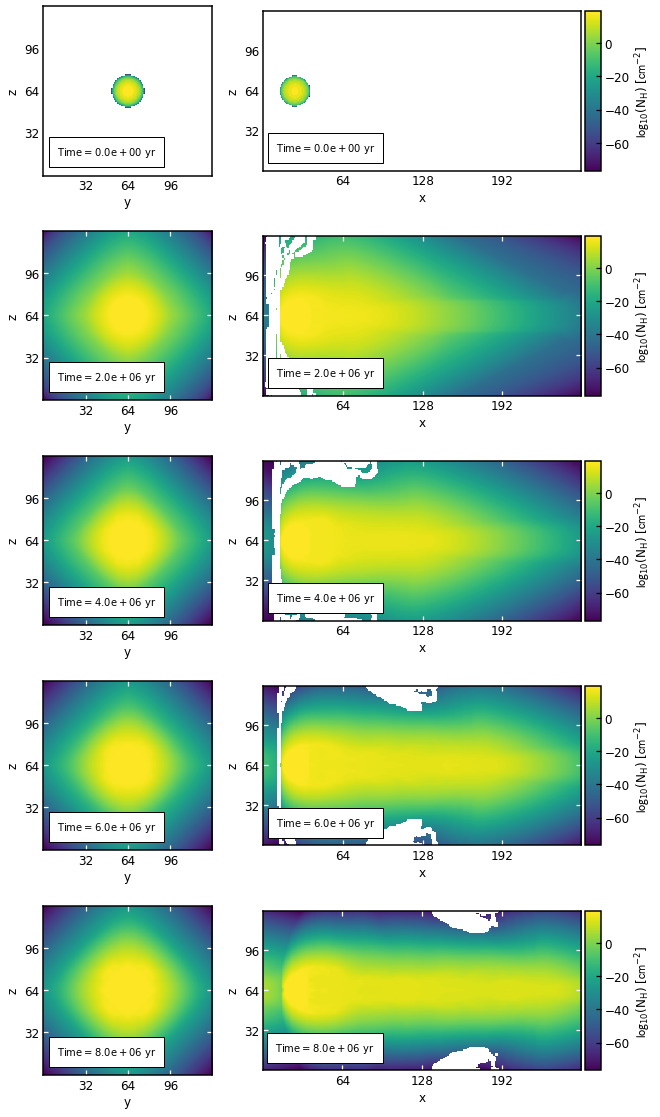

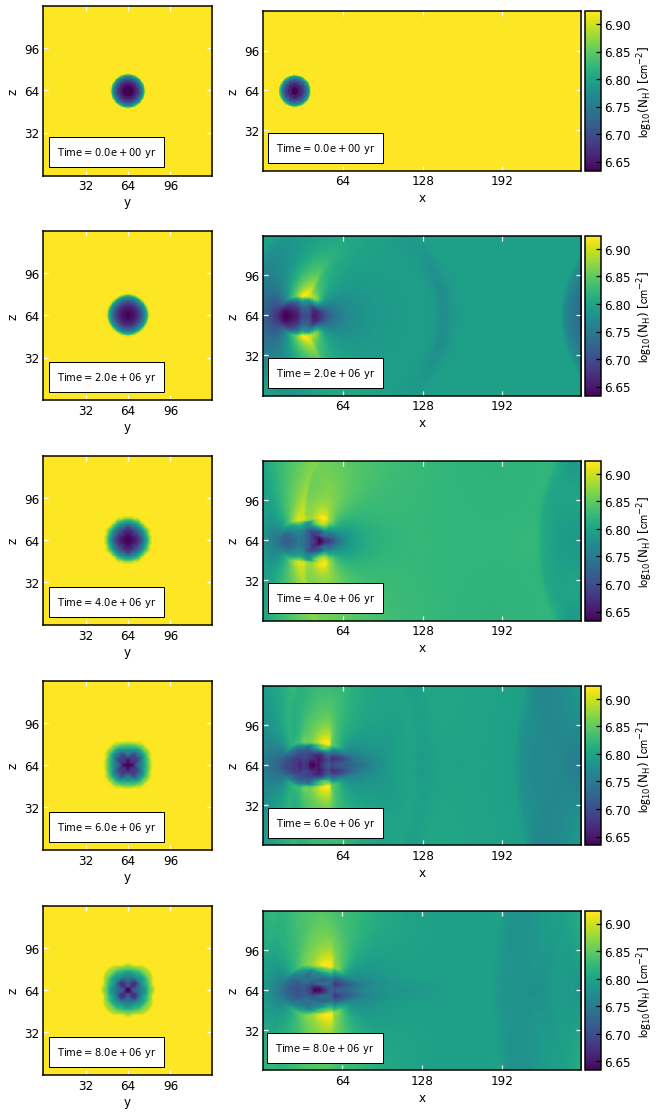

In [29]:
datav1000 = load_data("v1000")
plotter(datav1000, "gas")
plotter(datav1000, "dust")
plotter(datav1000, "velocity")